In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 3
N_CUTS = 4
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('2019-04-17', datetime.date(2022, 4, 17))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


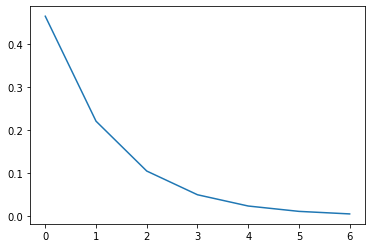

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.46566128730773904

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = [
    '^GSPC', # S&P 500
    '^IXIC', # Nasdaq
    '^NYA',  # NY Stock Exchange (total)
    '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [
    (first, second)
    for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
    for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-04-08  19.043186  7.402860  19.043186  7.402860  19.043186  7.402860   
2022-04-11  18.852863  7.262342  18.852863  7.262342  18.852863  7.262342   
2022-04-12  18.689837  7.176103  18.689837  7.176103  18.689837  7.176103   
2022-04-13  19.243916  7.359597  19.243916  7.359597  19.243916  7.359597   
2022-04-14  18.657302  7.120408  18.657302  7.120408  18.657302  7.120408   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-04-08  19.043186  7.402860  19.043186  7.402860  
2022-04-11  18.852863  7.262342  18.852863  7.262342  
2022-04-12  18.689837  7.176103  18.689837  7.176103  
2022-04-13  19.243916  7.359597  19.243916  7.359597  
2022-04-14  18.657302  7.120408  18.657302  7.120408

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                   Close                    High        ...  \
  ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC  ...   
0   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
1   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
2   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
3   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
4   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   

  DayToDayChange OvernightChange  LogValue IntradayChange DayToDayChange  \
          ^W5000          ^W5000     mine1          mine1          mine1   
0            NaN             NaN  0.011840            1.0            NaN   
1            NaN             NaN  0.006415            1.0       0.994589   
2            NaN             NaN -0.002226            1.0       0.991396   
3            NaN             NaN -0.005564            1.0       0.996668   
4            NaN             NaN -0.013576            1.0       0.992021   

  OvernightChange  LogValue IntradayChange DayToDayChange OvernightChange  
            mine1     mine2          mine2          mine2           mine2  
0             NaN  0.011840            1.0            NaN             NaN  
1        0.994589  0.006465            1.0       0.994640        0.994640  
2        0.991396 -0.002154            1.0       0.991417        0.991417  
3        0.996668 -0.005253            1.0       0.996907        0.996907  
4        0.992021 -0.013069            1.0       0.992214        0.992214  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

2512   2022-04-08
2513   2022-04-11
2514   2022-04-12
2515   2022-04-13
2516   2022-04-14
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                   Close                    High        ...  \
     ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC  ...   
Date                                                              ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   

     DayToDayChange OvernightChange  LogValue IntradayChange DayToDayChange  \
             ^W5000          ^W5000     mine1          mine1          mine1   
Date                                                                          
NaT             NaN             NaN  0.011840            1.0            NaN   
NaT             NaN             NaN  0.006415            1.0       0.994589   
NaT             NaN             NaN -0.002226            1.0       0.991396   
NaT             NaN             NaN -0.005564            1.0       0.996668   
NaT             NaN             NaN -0.013576            1.0       0.992021   

     OvernightChange  LogValue IntradayChange DayToDayChange OvernightChange  
               mine1     mine2          mine2          mine2           mine2  
Date                                                                          
NaT              NaN  0.011840            1.0            NaN             NaN  
NaT         0.994589  0.006465            1.0       0.994640        0.994640  
NaT         0.991396 -0.002154            1.0       0.991417        0.991417  
NaT         0.996668 -0.005253            1.0       0.996907        0.996907  
NaT         0.992021 -0.013069            1.0       0.992214        0.992214  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(
            f'Unexpected error getting {stock} data. Initialized as '
            f'None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'w') as f:
        json.dump(best_param_set, f)

In [20]:
SDS

array([0.46566129, 0.2213282 , 0.10519701, 0.05      , 0.02376493,
       0.01129544, 0.00536871])

SD: 0.2213282



----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.4131080660357649
Refitting current best...
Current best ma returns: 1.6173945291985738
Fraction Invested: 0.9999926338509283
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 1.6174184848068602
Invested: 0.9999926338509283
New best: 1.6174194471427095
Invested: 0.9999943194103047
New best: 1.6231783953148695
Invested: 0.9999943194103047
New best: 1.6231813829211543
Invested: 0.9999994174340621
New best: 1.62330951480672
Invested: 0.9999994174340621
New best: 1.6233101043302407
Invested: 0.9999994174340621
New best: 1.6233164005899645
Invested: 0.9999994174340621
New best: 1.6233239378304203
Invested: 0.9999994174340621
New best: 1.623324124366541
In

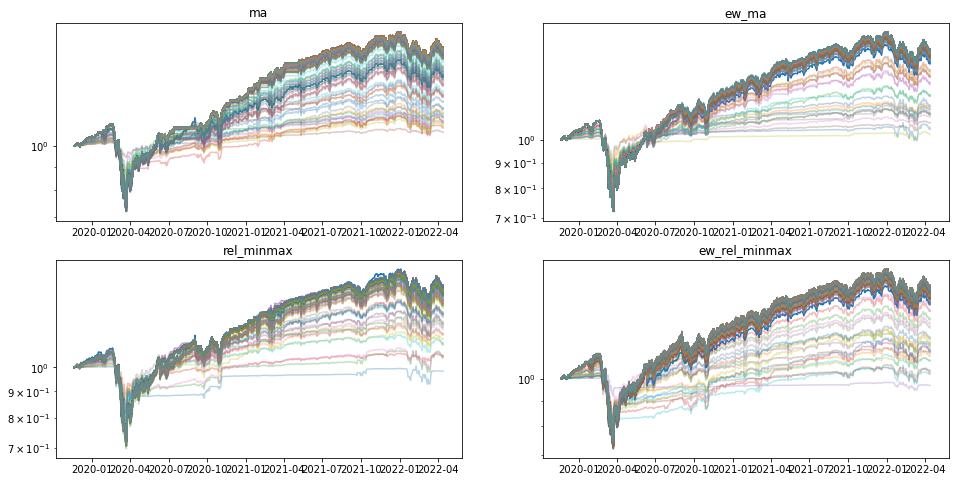

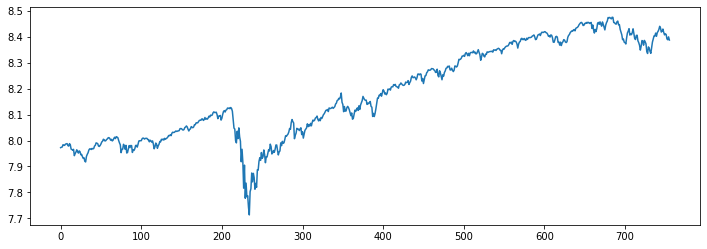

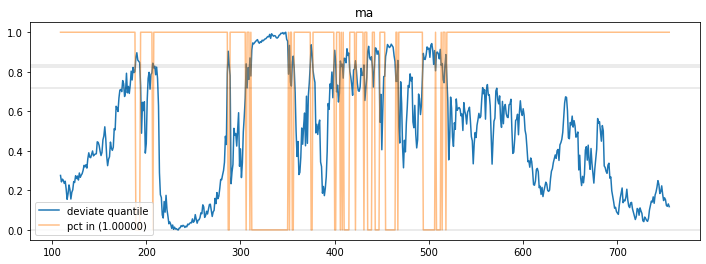

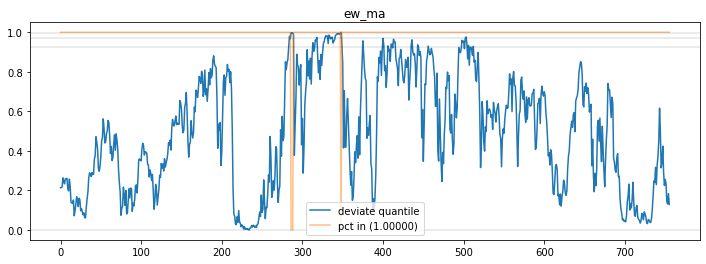

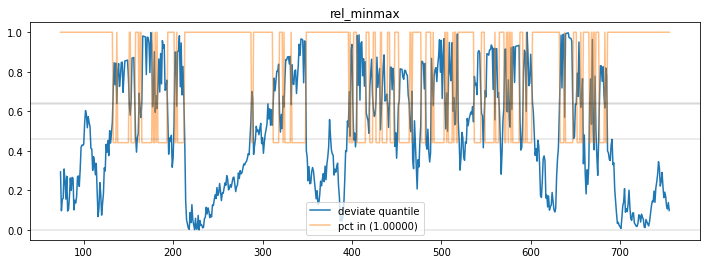

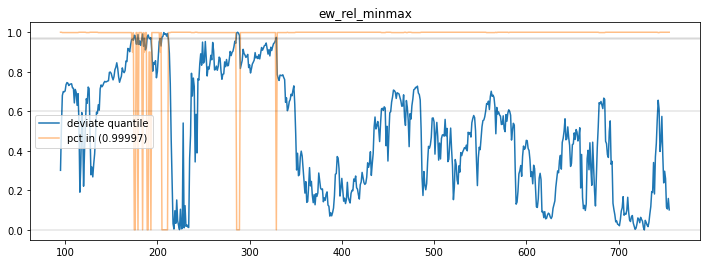

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.5657912639617233
Refitting current best...
Current best ma returns: 1.8267267710572395
Fraction Invested: 0.9999978061019762
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 1.8267271473904654
Invested: 0.9999978061019762
New best: 1.8267312005537628
Invested: 0.9999978061019762
New best: 1.8268009915273047
Invested: 0.9999978061019762
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.5657912639617233
Refitting current best...
Current best ew_ma returns: 1.7184905026762018
Fraction Invested: 0.9999752857303734
Beginning random search...
Round: 20
Beginning adjusted search...
Rou

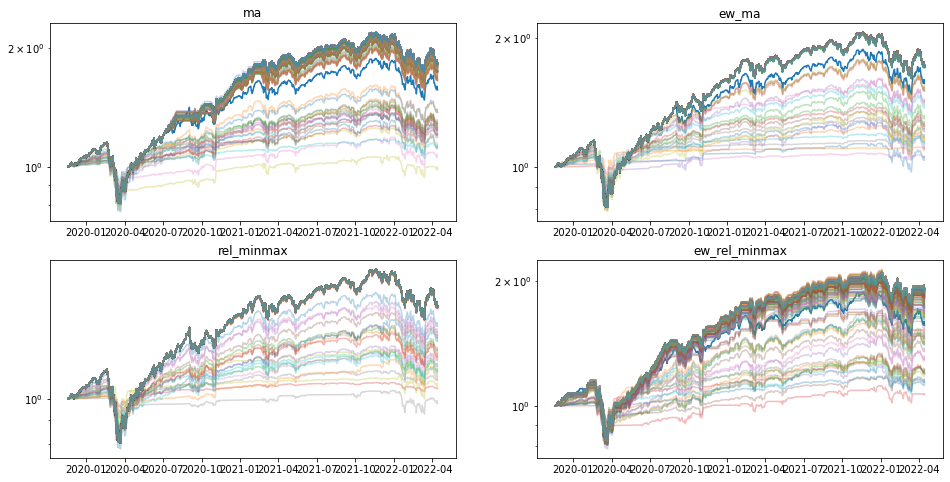

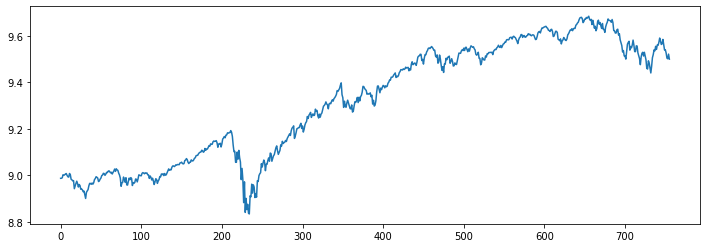

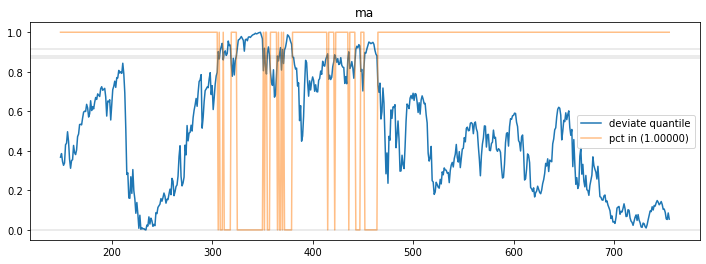

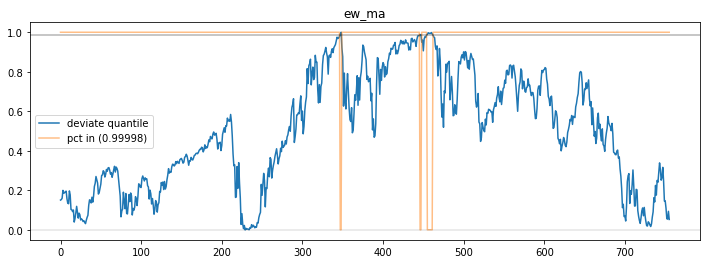

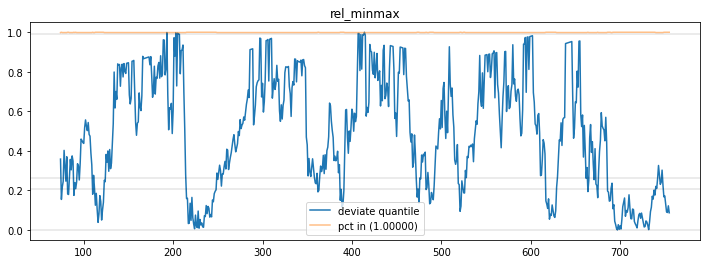

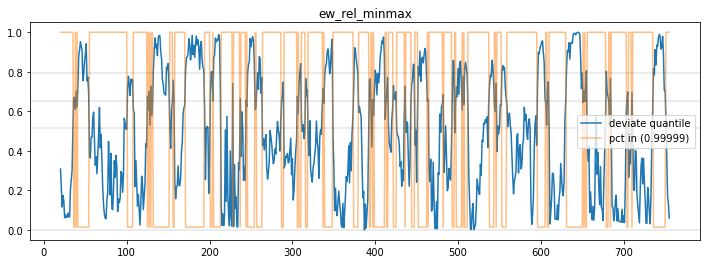

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.2304300526810914
Refitting current best...
Current best ma returns: 1.3037256170840474
Fraction Invested: 0.9985645552464597
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 1.3053037590388652
Invested: 0.9985645552464597
New best: 1.3053039119100402
Invested: 0.9985645552464597
New best: 1.3053701144495407
Invested: 0.9985645552464597
New best: 1.3053718862954171
Invested: 0.9985542481829035
New best: 1.305425155362651
Invested: 0.9985542481829035
New best: 1.305444815487552
Invested: 0.9985542481829035
New best: 1.3054451789027963
Invested: 0.9985542481829035
New best: 1.3054461353893612
Invested: 0.9985542481829035
New best: 1.3054563987

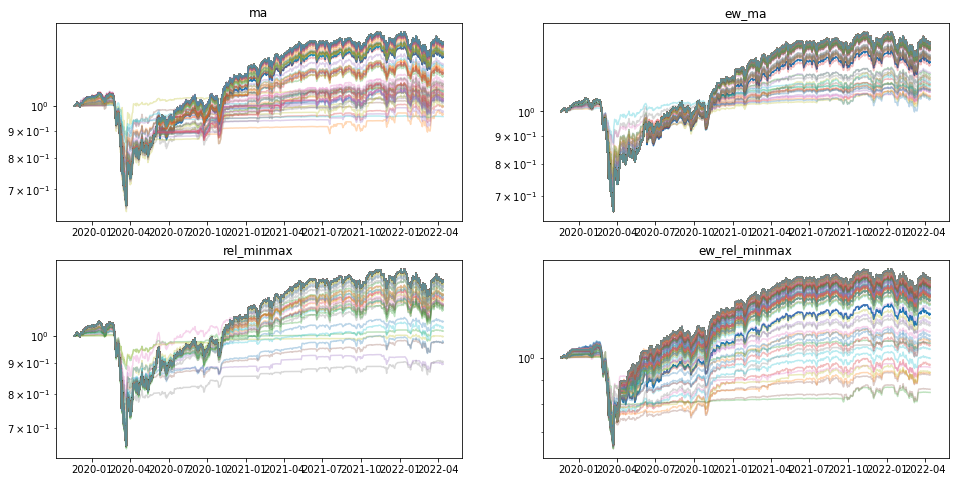

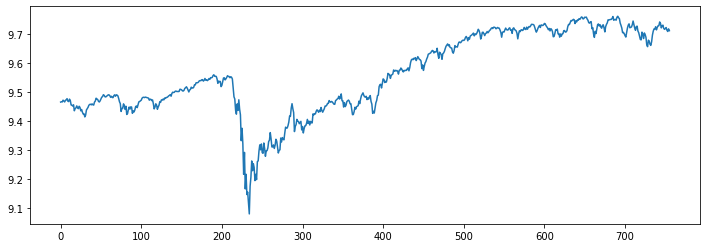

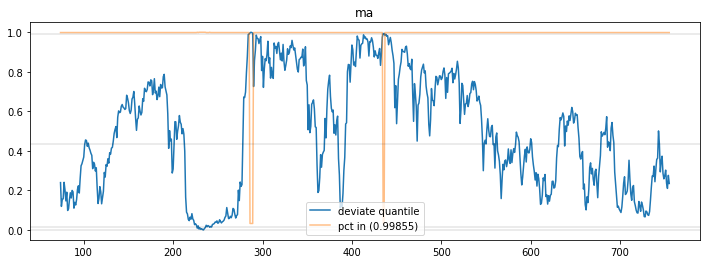

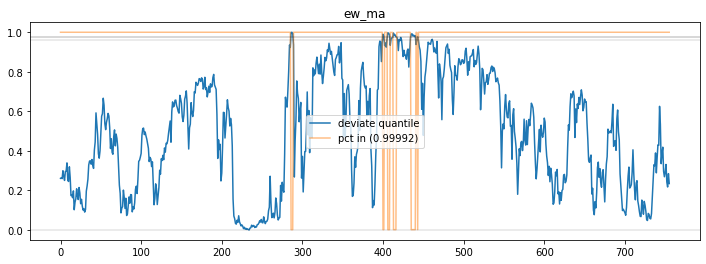

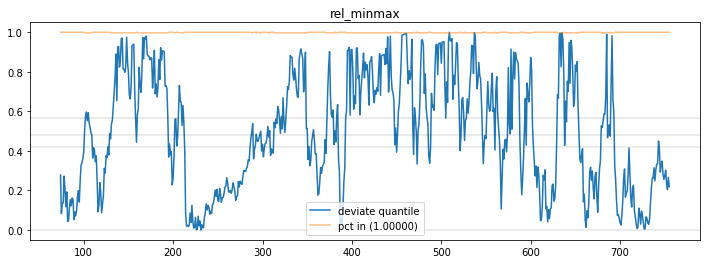

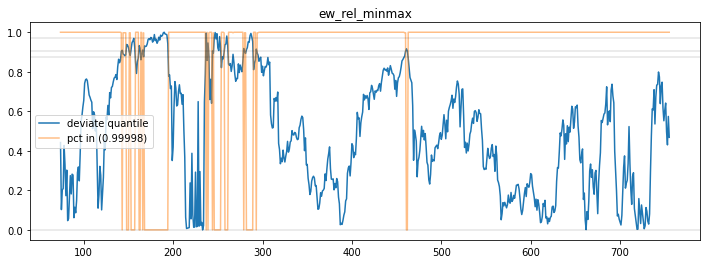

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.3952194085079372
Refitting current best...
Current best ma returns: 1.5779246230181716
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 1.5779345046942652
Invested: 1.0
New best: 1.5779525680950433
Invested: 1.0
New best: 1.5779525884438412
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.3952194085079372
Refitting current best...
Current best ew_ma returns: 1.5305122990610678
Fraction Invested: 0.9999778369614254
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 1.5378807672341277
Invested: 0.9999778369614254
New b

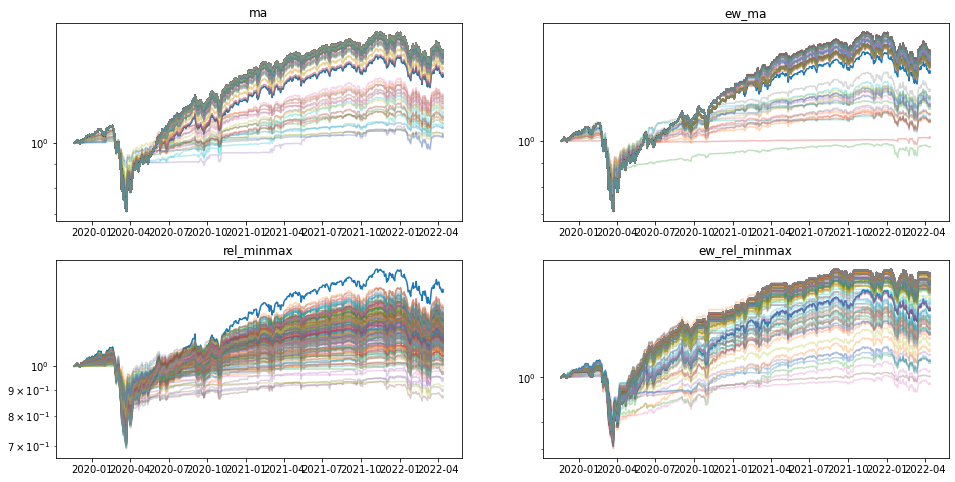

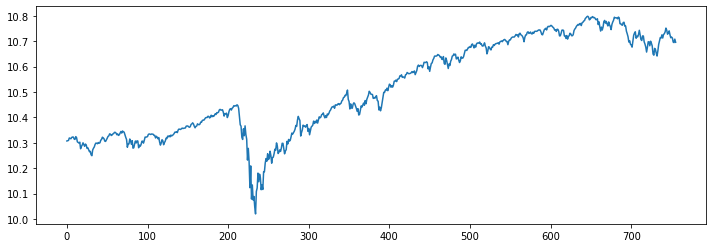

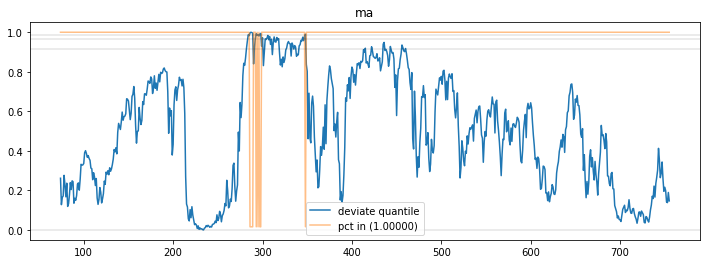

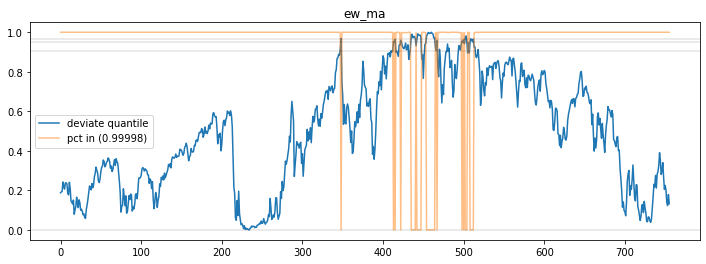

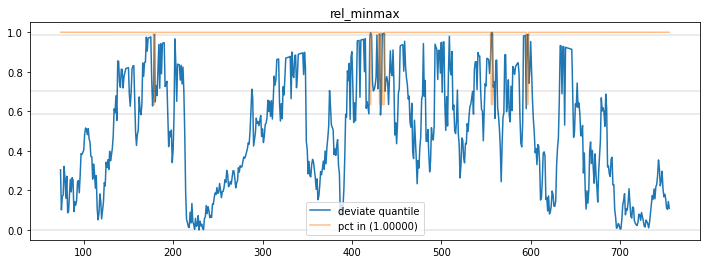

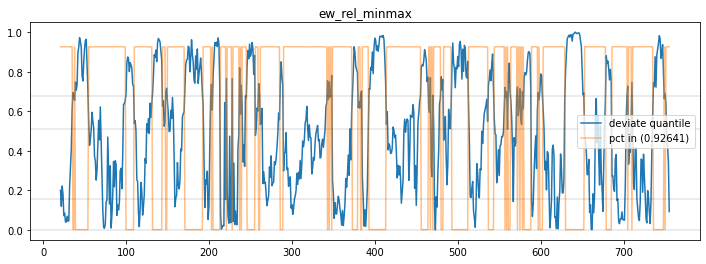

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.2631476866420646
Refitting current best...
Current best ma returns: 2.479693848235084
Fraction Invested: 0.9999957546742771
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 2.4796944400137484
Invested: 0.9999962318423496
New best: 2.479694845575873
Invested: 0.9999965588587498
New best: 2.4796957198309078
Invested: 0.9999965588587498
New best: 2.4796979101515357
Invested: 0.9999981439639052
Round: 180 177


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.2631476866420646
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing rando

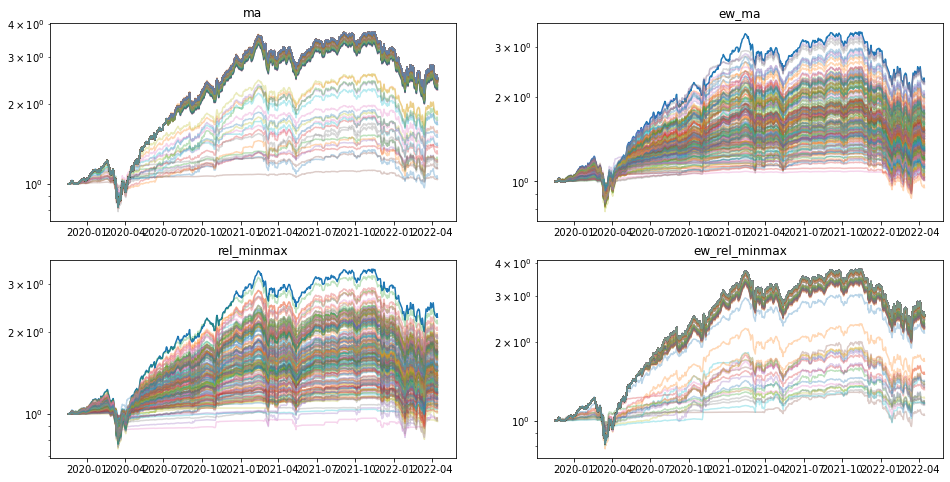

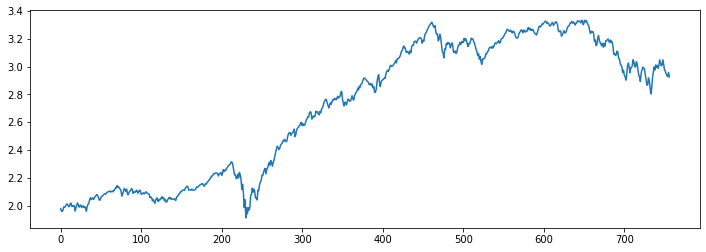

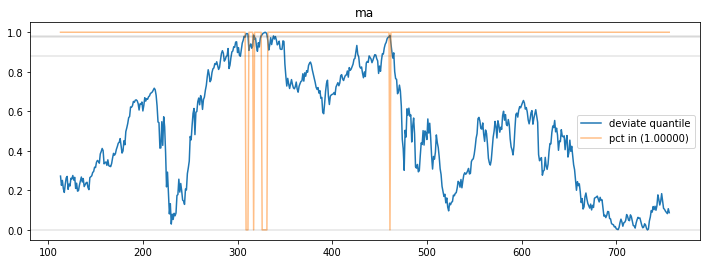

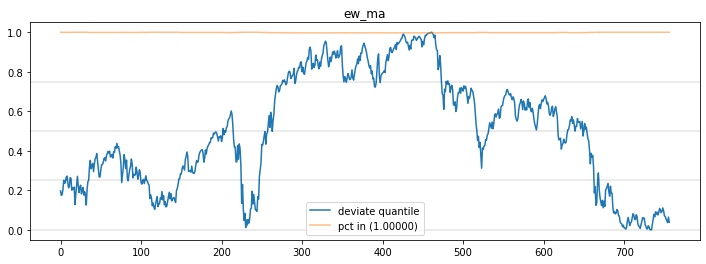

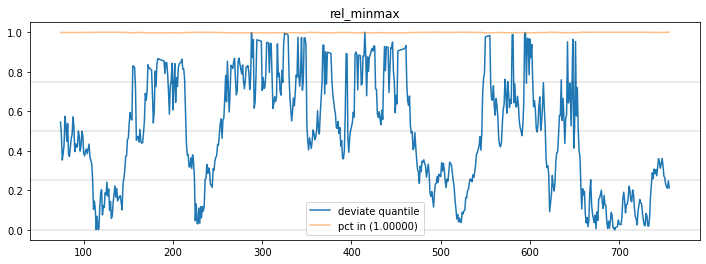

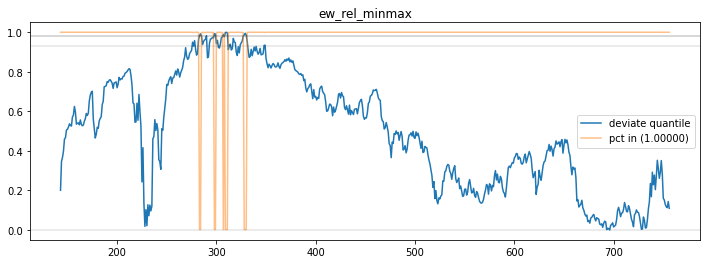

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.5993369731800429
Refitting current best...
Current best ma returns: 1.9705750913853304
Fraction Invested: 0.9998738848353491
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 1.974080915849092
Invested: 0.9998738848353491
New best: 1.9740941599785016
Invested: 0.9998882552080924
New best: 1.9743778105132732
Invested: 0.9998882552080924
New best: 1.97441702747365
Invested: 0.999930800960194
New best: 1.9784786538093329
Invested: 0.999930800960194
New best: 1.9784963705620038
Invested: 0.9999499832180706
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.5993369731800429
Refitting c

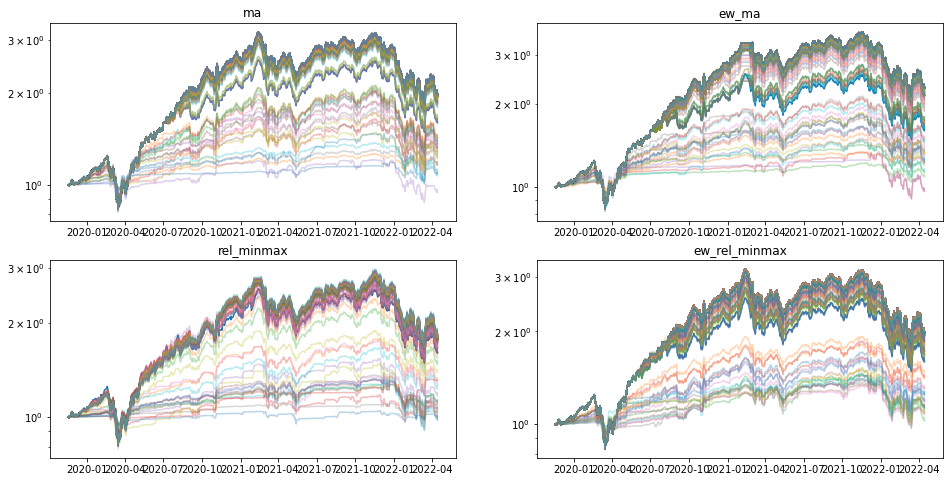

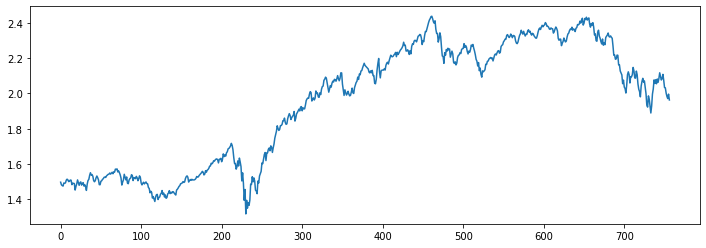

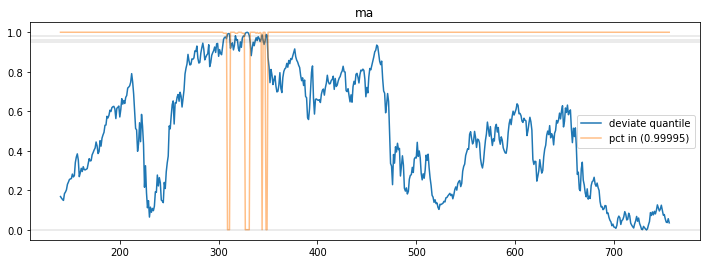

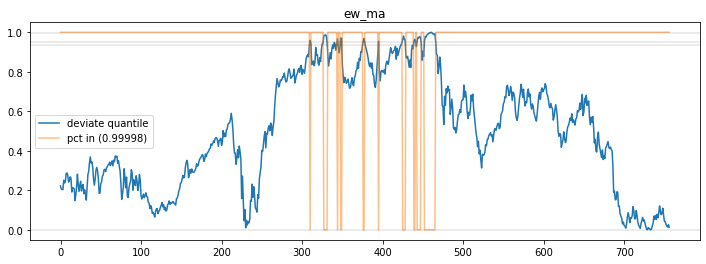

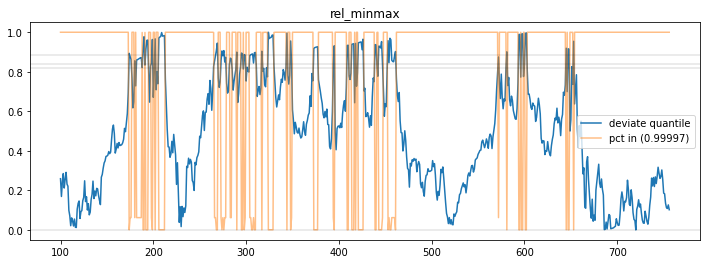

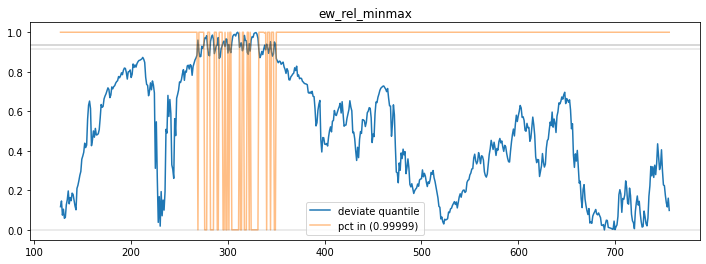

Saving mine2 params...


In [21]:
SD = 0.2213282
N_RAND = 20
N_ADJ = 180

#N_RAND = 5
#N_ADJ = 45

print('SD:', SD)
do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(
            stock_data, 
            N_CUTS, 
            best_param_set=best_params, 
            best_returns=best_returns, 
            sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [22]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = {'best_return': best_return, 'pct_in': best_pct}
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [23]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 1.6233242867274962 (ma)
  0.99999990 in
time param: 110
qs:
(0.0000 - 0.7161): 1.0000
(0.7161 - 0.8243): 1.0000
(0.8243 - 0.8339): 0.9999
(0.8339 - 1.0000): 0.0001

^IXIC:
  Best Return: 1.9137265619849753 (ew_rel_minmax)
  0.99998581 in
time param: 21
qs:
(0.0000 - 0.5154): 1.0000
(0.5154 - 0.6533): 0.9996
(0.6533 - 0.7927): 0.0140
(0.7927 - 1.0000): 0.0140

^NYA:
  Best Return: 1.4559339887900964 (ew_rel_minmax)
  0.99997606 in
time param: 75
qs:
(0.0000 - 0.8761): 1.0000
(0.8761 - 0.9040): 0.9974
(0.9040 - 0.9684): 0.0002
(0.9684 - 1.0000): 0.0000

^W5000:
  Best Return: 1.6611321756696846 (ew_rel_minmax)
  0.92641095 in
time param: 22
qs:
(0.0000 - 0.1572): 0.9264
(0.1572 - 0.5098): 0.9264
(0.5098 - 0.6797): 0.9258
(0.6797 - 1.0000): 0.0014

mine1:
  Best Return: 2.521600188700959 (ew_rel_minmax)
  0.99999944 in
time param: 144
qs:
(0.0000 - 0.9290): 1.0000
(0.9290 - 0.9833): 0.9992
(0.9833 - 0.9834): 0.0807
(0.9834 - 1.0000): 0.0021

mine2:
  Best Return: 2.

{'^GSPC': {'best_return': 1.6233242867274962, 'pct_in': 0.9999998959943376},
 '^IXIC': {'best_return': 1.9137265619849753, 'pct_in': 0.9999858087330544},
 '^NYA': {'best_return': 1.4559339887900964, 'pct_in': 0.9999760641207338},
 '^W5000': {'best_return': 1.6611321756696846, 'pct_in': 0.9264109492094144},
 'mine1': {'best_return': 2.521600188700959, 'pct_in': 0.9999994399475789},
 'mine2': {'best_return': 2.281567523296265, 'pct_in': 0.9999767541641612}}

In [24]:
do_nothing_returns

{'^GSPC': 1.4131080660357649,
 '^IXIC': 1.5657912639617233,
 '^NYA': 1.2304300526810914,
 '^W5000': 1.3952194085079372,
 'mine1': 2.2631476866420646,
 'mine2': 1.5993369731800429}

In [25]:
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]['best_return']
    den = do_nothing_returns[stock]
    weight = (num / den) - 1
    if weight <= 0:
        weight = 0
    if stock.startswith('mine'):
        weight /= 2
    best_returns[stock]['weight'] = weight
best_returns

{'^GSPC': {'best_return': 1.6233242867274962,
  'pct_in': 0.9999998959943376,
  'weight': 0.14876160269996697},
 '^IXIC': {'best_return': 1.9137265619849753,
  'pct_in': 0.9999858087330544,
  'weight': 0.2222105245005106},
 '^NYA': {'best_return': 1.4559339887900964,
  'pct_in': 0.9999760641207338,
  'weight': 0.1832724547142155},
 '^W5000': {'best_return': 1.6611321756696846,
  'pct_in': 0.9264109492094144,
  'weight': 0.19058849492791774},
 'mine1': {'best_return': 2.521600188700959,
  'pct_in': 0.9999994399475789,
  'weight': 0.05710022893874245},
 'mine2': {'best_return': 2.281567523296265,
  'pct_in': 0.9999767541641612,
  'weight': 0.2132854306368308}}

In [26]:
with open(f'{DATA}/qp_{N_YEARS}_weights.json', 'w') as f:
    json.dump(best_returns, f)

In [28]:
!say qp 3 is dunzo